In [1]:
# Install dependencies if not already installed
# pip install nba_api pandas tqdm

import pandas as pd
import time
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from requests.exceptions import ReadTimeout
from tqdm import tqdm

# --- CONFIGURATION ---
season = '2023-24'  # Correct season format
output_file = f'nba_all_players_game_logs_{season}.csv'

# --- Fetch active players ---
all_players = players.get_active_players()
print(f"Total active players found: {len(all_players)}")

# --- Initialize list to hold player logs ---
all_logs = []

# --- Loop through each player ---
for idx, player in enumerate(tqdm(all_players, desc="Fetching players")):
    player_id = player['id']
    player_name = player['full_name']
    
    # Retry logic for timeouts
    retries = 3
    while retries > 0:
        try:
            logs = playergamelog.PlayerGameLog(player_id=player_id, season=season).get_data_frames()[0]
            break
        except ReadTimeout:
            print(f"Timeout for {player_name}, retrying...")
            retries -= 1
            time.sleep(2)
    else:
        print(f"Failed to fetch data for {player_name} after retries.")
        logs = pd.DataFrame()  # Empty DataFrame for failed player
    
    if not logs.empty:
        logs['PLAYER_NAME'] = player_name  # Add player name column
        all_logs.append(logs)
    
    time.sleep(0.8)  # Delay to avoid API throttling

# --- Combine all player logs ---
if all_logs:
    combined_df = pd.concat(all_logs, ignore_index=True)
else:
    combined_df = pd.DataFrame()

print(f"Combined dataset shape: {combined_df.shape}")

# --- Save to CSV ---
combined_df.to_csv(output_file, index=False)
print(f"Dataset saved as '{output_file}'")


Total active players found: 572


Fetching players:  28%|██████▍                | 159/572 [02:41<19:03,  2.77s/it]

Timeout for Enrique Freeman, retrying...


Fetching players: 100%|███████████████████████| 572/572 [15:11<00:00,  1.59s/it]

Combined dataset shape: (23770, 28)
Dataset saved as 'nba_all_players_game_logs_2023-24.csv'


In [4]:

# Load the dataset
df = pd.read_csv('nba_all_players_game_logs_2023-24.csv')

# 1. Basic info
print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n", df.dtypes)

# 2. Quick look at the first 5 rows
print("\nFirst 5 rows:\n", df.head())

# 3. Summary statistics for numeric columns
print("\nSummary statistics:\n", df.describe())

# 4. Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())

# 5. Number of unique players
print("\nUnique players in dataset:", df['PLAYER_NAME'].nunique())

# 6. Top 5 players by number of games
top_players = df['PLAYER_NAME'].value_counts().head()
print("\nTop 5 players by games played:\n", top_players)

# 7. Average points per game for each player
avg_points = df.groupby('PLAYER_NAME')['PTS'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 players by average points per game:\n", avg_points)


Dataset shape: (23770, 28)

Column names:
 Index(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE', 'PLAYER_NAME'],
      dtype='object')

Data types:
 SEASON_ID            int64
Player_ID            int64
Game_ID              int64
GAME_DATE           object
MATCHUP             object
WL                  object
MIN                  int64
FGM                  int64
FGA                  int64
FG_PCT             float64
FG3M                 int64
FG3A                 int64
FG3_PCT            float64
FTM                  int64
FTA                  int64
FT_PCT             float64
OREB                 int64
DREB                 int64
REB                  int64
AST                  int64
STL                  int64
BLK                  int64
TOV                  int64
PF        

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23770 entries, 0 to 23769
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEASON_ID        23770 non-null  int64  
 1   Player_ID        23770 non-null  int64  
 2   Game_ID          23770 non-null  int64  
 3   GAME_DATE        23770 non-null  object 
 4   MATCHUP          23770 non-null  object 
 5   WL               23770 non-null  object 
 6   MIN              23770 non-null  int64  
 7   FGM              23770 non-null  int64  
 8   FGA              23770 non-null  int64  
 9   FG_PCT           23770 non-null  float64
 10  FG3M             23770 non-null  int64  
 11  FG3A             23770 non-null  int64  
 12  FG3_PCT          23770 non-null  float64
 13  FTM              23770 non-null  int64  
 14  FTA              23770 non-null  int64  
 15  FT_PCT           23770 non-null  float64
 16  OREB             23770 non-null  int64  
 17  DREB        

Total players: 448
Total games: 1230
Average points per game: 11.341144299537232
Average rebounds per game: 4.275010517458982
Average assists per game: 2.6312578880942366

Top 10 players by PPG:
PLAYER_NAME
Joel Embiid                34.692308
Luka Dončić                33.857143
Giannis Antetokounmpo      30.438356
Shai Gilgeous-Alexander    30.053333
Jalen Brunson              28.727273
Kevin Durant               27.093333
Devin Booker               27.073529
Jayson Tatum               26.851351
Donovan Mitchell           26.600000
De'Aaron Fox               26.567568
Name: PTS, dtype: float64

Top 10 players by games played:
PLAYER_NAME
Buddy Hield          84
Reggie Jackson       82
Harrison Barnes      82
Cason Wallace        82
Jonas Valančiūnas    82
Obi Toppin           82
Christian Braun      82
Mikal Bridges        82
Bobby Portis         82
Jalen Green          82
Name: count, dtype: int64


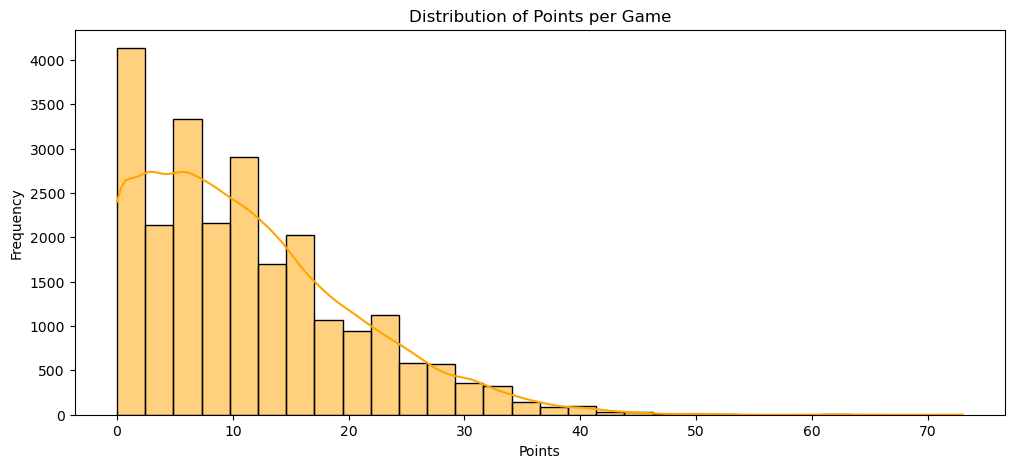

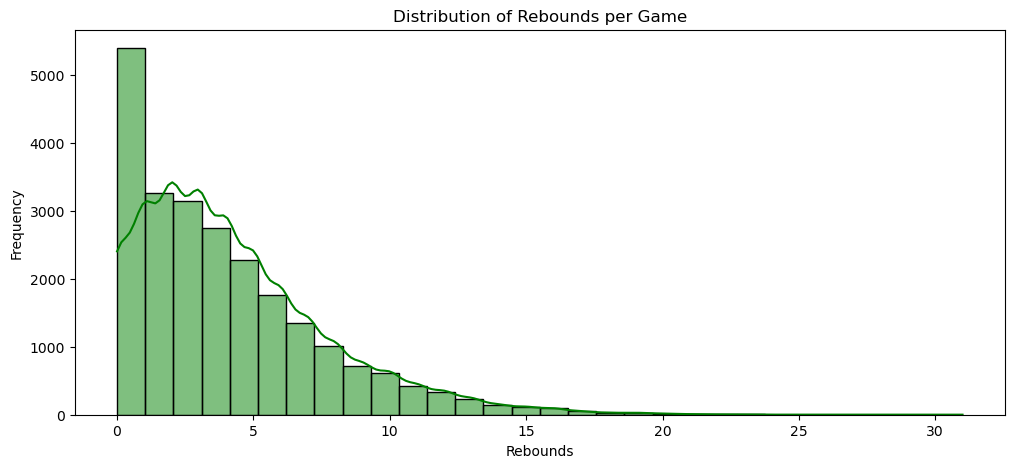

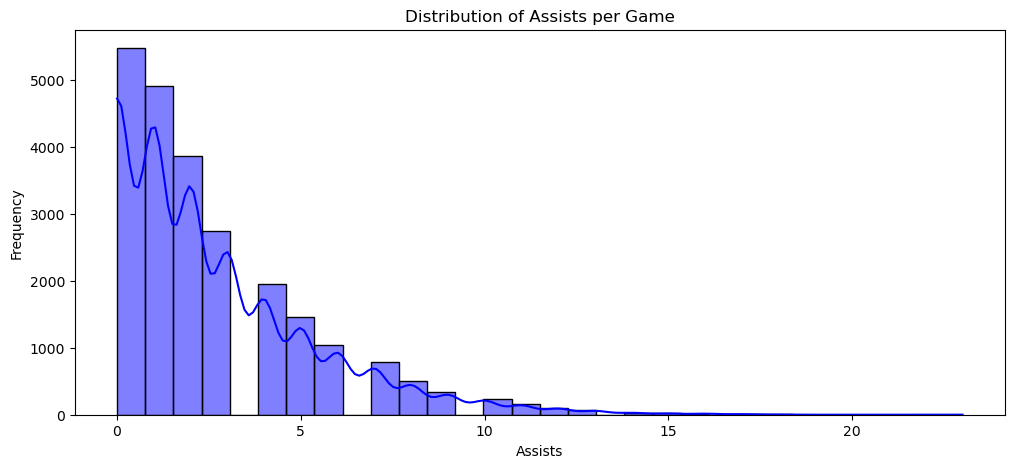

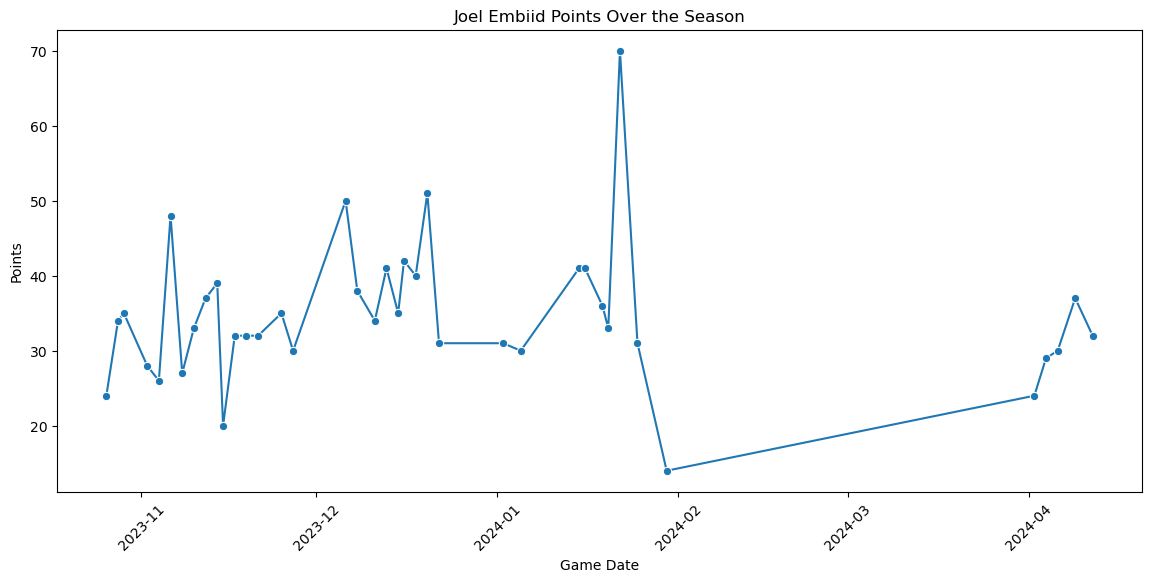

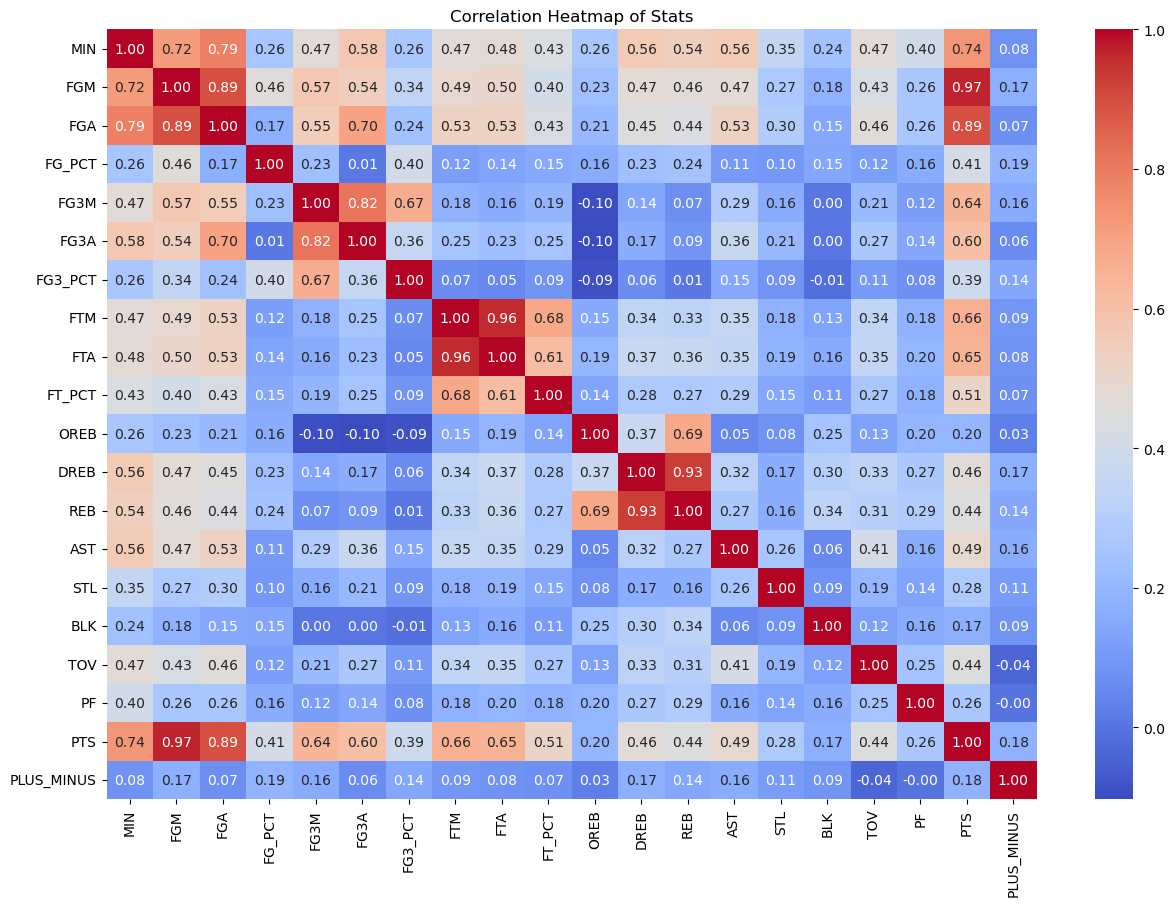

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('nba_all_players_game_logs_2023-24.csv')

# Convert GAME_DATE to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Extract Home/Away and Opponent
df['HOME'] = df['MATCHUP'].apply(lambda x: 'Home' if '@' not in x else 'Away')
df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split()[-1])

# -------------------------
#  General Stats
# -------------------------
print("Total players:", df['PLAYER_NAME'].nunique())
print("Total games:", df['Game_ID'].nunique())
print("Average points per game:", df['PTS'].mean())
print("Average rebounds per game:", df['REB'].mean())
print("Average assists per game:", df['AST'].mean())

# -------------------------
#  Top Players
# -------------------------
top_pts = df.groupby('PLAYER_NAME')['PTS'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 players by PPG:")
print(top_pts)

top_games = df['PLAYER_NAME'].value_counts().head(10)
print("\nTop 10 players by games played:")
print(top_games)

# -------------------------
#  Distributions
# -------------------------
plt.figure(figsize=(12,5))
sns.histplot(df['PTS'], bins=30, kde=True, color='orange')
plt.title('Distribution of Points per Game')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['REB'], bins=30, kde=True, color='green')
plt.title('Distribution of Rebounds per Game')
plt.xlabel('Rebounds')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df['AST'], bins=30, kde=True, color='blue')
plt.title('Distribution of Assists per Game')
plt.xlabel('Assists')
plt.ylabel('Frequency')
plt.show()

# -------------------------
#  Points over Time for Top Player
# -------------------------
top_player = top_pts.index[0]
player_df = df[df['PLAYER_NAME'] == top_player].sort_values('GAME_DATE')

plt.figure(figsize=(14,6))
sns.lineplot(x='GAME_DATE', y='PTS', data=player_df, marker='o')
plt.title(f'{top_player} Points Over the Season')
plt.xlabel('Game Date')
plt.ylabel('Points')
plt.xticks(rotation=45)
plt.show()

# -------------------------
#  Correlation Heatmap
# -------------------------
numeric_cols = ['MIN','FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA',
                'FT_PCT','OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS','PLUS_MINUS']

plt.figure(figsize=(15,10))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Stats')
plt.show()
